# Train a scVI model using Lamin

This notebook demonstrates a scalable approach to training an [scVI](https://docs.scvi-tools.org/en/latest/user_guide/models/scvi.html) model on Census data using [Lamin](https://lamin.ai/) dataloader.
LaminDB is a database system based on its MappedCollection designed to support efficient storage, management, and querying of scientific data, particularly in machine learning, bioinformatics, and data science applications. It allows for the easy organization, sharing, and querying of complex datasets, such as those involved in research, experiments, or models.
See [here](https://docs.scvi-tools.org/en/stable/user_guide/use_case/custom_dataloaders.html) for more information

```{note}
Running the following cell will install tutorial dependencies on Google Colab only. It will have no effect on environments other than Google Colab.
```

In [1]:
!pip install --quiet scvi-colab==0.13.0


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [2]:
!pip install --quiet "lamindb[bionty,jupyter]>=1.3.0"
!pip install --quiet biomart
!pip install --quiet bionty
!pip install --quiet cellxgene_lamin
!pip install --quiet urllib3==1.26.20
!pip install --quiet tiledbsoma
!pip install --quiet tiledb
!pip install --quiet tiledbsoma_ml
!pip install --quiet cellxgene-census


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip insta

In [3]:
# We will need to initialzie the lamindb instance
!lamin connect laminlabs/cellxgene

→ connected lamindb: laminlabs/cellxgene


In [4]:
# A Manual fix to uv issue in Colab, see: https://github.com/astral-sh/uv/issues/12724
import os

os.environ["UV_CONSTRAINT"] = os.environ["UV_BUILD_CONSTRAINT"] = ""

In [5]:
from scvi_colab import install

install(branch="ori-2907-custom-dataloader-registry", for_tutorials=False)

/opt/miniconda3/envs/scvi/lib/python3.12/site-packages/scvi_colab/_core.py:47: UserWarning: 
                Not currently in Google Colab environment.

                Please run with `run_outside_colab=True` to override.

                Returning with no further action.
                
  warn(


In [6]:
import os

import scanpy as sc
import scvi
from scvi.dataloaders import MappedCollectionDataModule

→ connected lamindb: laminlabs/cellxgene


In [7]:
!lamin init --storage ./lamindb_collection  # one time for github runner (comment)
import lamindb as ln
# ln.setup.init()  # one time for github runner (comment out when runing localy)

In [8]:
# ln.track()

In [9]:
# We load the collection to see it consists of many h5ad files
collection = ln.Collection.using("laminlabs/cellxgene").get(name="covid_normal_lung")
artifacts = collection.artifacts.all()
artifacts.df()

! no run & transform got linked, call `ln.track()` & re-run


,uid,key,description,suffix,kind,otype,size,hash,n_files,n_observations,_hash_type,_key_is_virtual,_overwrite_versions,space_id,storage_id,schema_id,version,is_latest,run_id,created_at,created_by_id,_aux,_branch_code
id,,,,,,,,,,,,,,,,,,,,,,,
2894,7uWdx2sU0D0ujw5YXrHs,cell-census/2024-07-01/h5ads/0ba16f4b-cb87-4fa...,Myeloid,.h5ad,dataset,AnnData,84794822,F3RByNhyDKAexaU4LODH4g,None,6947,md5-n,False,False,1,2,None,2024-07-01,True,27,2024-07-12 12:34:08.908938+00:00,1,None,1
2905,5VCheRCxgdRWtDnBNVQC,cell-census/2024-07-01/h5ads/0e9d47fb-89b1-42d...,Airway epithelial cells,.h5ad,dataset,AnnData,444425539,rF2Y_n0Fg_rNvc9Zq8zgvA,None,29505,md5-n,False,False,1,2,None,2024-07-01,True,27,2024-07-12 12:34:08.926925+00:00,1,None,1
3001,sahSoRDphdi5QINmYKga,cell-census/2024-07-01/h5ads/2d85960a-2ba8-4f5...,Myeloid cells,.h5ad,dataset,AnnData,477060382,16ejFHaCfxlQ2GMtgb8lbQ,None,40634,md5-n,False,False,1,2,None,2024-07-01,True,27,2024-07-12 12:34:09.129814+00:00,1,None,1
3005,HpnxGOoYonDkD4UIEP9V,cell-census/2024-07-01/h5ads/2f132ec9-24b5-422...,Lung,.h5ad,dataset,AnnData,358508307,16xp2QLMQeC910m_7DEWTQ,None,39778,md5-n,False,False,1,2,None,2024-07-01,True,27,2024-07-12 12:34:09.138873+00:00,1,None,1
3043,h1OfBAUVyqCe47TmODzc,cell-census/2024-07-01/h5ads/3de0ad6d-4378-4f6...,Single-cell multiomic profiling of human lungs...,.h5ad,dataset,AnnData,352144365,-TosSu-93OSu_jhPk0cOQQ,None,46500,md5-n,False,False,1,2,None,2024-07-01,True,27,2024-07-12 12:34:09.212862+00:00,1,None,1
3096,qV5esGG2dDXlcEYVNlcp,cell-census/2024-07-01/h5ads/4ebcbeeb-2208-4d3...,Vascular endothelial cells,.h5ad,dataset,AnnData,194059730,JzQWkYD4qxNfb7S-5rpDFQ,None,20855,md5-n,False,False,1,2,None,2024-07-01,True,27,2024-07-12 12:34:09.324041+00:00,1,None,1
3157,0EvCxCNIHX5sJ5SuiJc4,cell-census/2024-07-01/h5ads/62315937-e268-4fa...,"T, NK and ILC",.h5ad,dataset,AnnData,48914732,CLWqAhLiHdiA9R9b7nboBQ,None,4778,md5-n,False,False,1,2,None,2024-07-01,True,27,2024-07-12 12:34:09.430883+00:00,1,None,1
3189,yBlPj8fH71ZpQzzICcyd,cell-census/2024-07-01/h5ads/703f00e6-b996-48e...,PNS,.h5ad,dataset,AnnData,12575655,1UJhLvRP0EveA1DqXEahxA,None,649,md5-n,False,False,1,2,None,2024-07-01,True,27,2024-07-12 12:34:09.492181+00:00,1,None,1
3223,5v0IoJIlnuX4q1y57LDy,cell-census/2024-07-01/h5ads/7b3368a5-c1a0-497...,B cells,.h5ad,dataset,AnnData,42340721,XMc31Q7EW4ychA4jMKJiqA,None,4138,md5-n,False,False,1,2,None,2024-07-01,True,27,2024-07-12 12:34:09.553054+00:00,1,None,1


In [10]:
# we can now define the batch and data loader
batch_keys = "assay"
datamodule = MappedCollectionDataModule(
    collection,
    batch_key=batch_keys,
    batch_size=1024,
    join="inner",
)

/opt/miniconda3/envs/scvi/lib/python3.12/site-packages/scvi/dataloaders/_custom_dataloders.py:68: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator=='mps' in train function.In future releases it will become default for mps supported machines.
  _, _, self.device = parse_device_args(


In [11]:
print(datamodule.n_obs, datamodule.n_vars, datamodule.n_batch)

343281 11771 6


In [12]:
print(datamodule.registry)

{'scvi_version': '1.3.1', 'model_name': 'SCVI', 'setup_args': {'layer': None, 'batch_key': 'assay', 'labels_key': None, 'size_factor_key': None, 'categorical_covariate_keys': None, 'continuous_covariate_keys': None}, 'field_registries': {'X': {'data_registry': {'attr_name': 'X', 'attr_key': None}, 'state_registry': {'n_obs': 343281, 'n_vars': 11771, 'column_names': Index(['ENSG00000237491', 'ENSG00000225880', 'ENSG00000230368',
       'ENSG00000187634', 'ENSG00000188976', 'ENSG00000187961',
       'ENSG00000188290', 'ENSG00000187608', 'ENSG00000188157',
       'ENSG00000078808',
       ...
       'ENSG00000182871', 'ENSG00000173638', 'ENSG00000142156',
       'ENSG00000142173', 'ENSG00000160294', 'ENSG00000182362',
       'ENSG00000160299', 'ENSG00000160305', 'ENSG00000160307',
       'ENSG00000160310'],
      dtype='object', length=11771)}, 'summary_stats': {'n_vars': 11771, 'n_cells': 343281}}, 'batch': {'data_registry': {'attr_name': 'obs', 'attr_key': '_scvi_batch'}, 'state_registr

In [13]:
# Init the model
model = scvi.model.SCVI(registry=datamodule.registry)

In [14]:
# Training the model
model.train(
    max_epochs=1,
    batch_size=1024,
    datamodule=datamodule,
)

/opt/miniconda3/envs/scvi/lib/python3.12/site-packages/scvi/train/_trainrunner.py:69: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator=='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/miniconda3/envs/scvi/lib/python3.12/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/opt/miniconda3/envs/scvi/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


→ connected lamindb: anonymous/lamindb_collection
→ connected lamindb: anonymous/lamindb_collection
→ connected lamindb: anonymous/lamindb_collection
→ connected lamindb: anonymous/lamindb_collection
→ connected lamindb: anonymous/lamindb_collection
→ connected lamindb: anonymous/lamindb_collection
→ connected lamindb: anonymous/lamindb_collection


Training:   0%|          | 0/1 [00:00<?, ?it/s]

/opt/miniconda3/envs/scvi/lib/python3.12/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/opt/miniconda3/envs/scvi/lib/python3.12/site-packages/lightning/pytorch/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 1024. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/opt/miniconda3/envs/scvi/lib/python3.12/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/opt/miniconda3/envs/scvi/lib/python3.12/site-packages/lightning/pytorch/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 241. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.

In [15]:
# Save the model
model.save("lamin_model", save_anndata=False, overwrite=True, datamodule=datamodule)

In [16]:
model.history.keys()

dict_keys(['kl_weight', 'train_loss_step', 'train_loss_epoch', 'elbo_train', 'reconstruction_loss_train', 'kl_local_train', 'kl_global_train'])

In [17]:
# The way to extract the internal model analysis is by the inference_dataloader
# Datamodule will always require to pass it into all downstream functions.
inference_dataloader = datamodule.inference_dataloader()
latent = model.get_latent_representation(dataloader=inference_dataloader)

→ connected lamindb: anonymous/lamindb_collection
→ connected lamindb: anonymous/lamindb_collection
→ connected lamindb: anonymous/lamindb_collection
→ connected lamindb: anonymous/lamindb_collection
→ connected lamindb: anonymous/lamindb_collection
→ connected lamindb: anonymous/lamindb_collection
→ connected lamindb: anonymous/lamindb_collection


In [18]:
# We extract the adata of the model, to be able to plot it
adata = collection.load(join="inner")

/opt/miniconda3/envs/scvi/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/opt/miniconda3/envs/scvi/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [19]:
adata.obsm["scvi"] = latent

In [22]:
adata.obs

,suspension_type,donor_id,assay_ontology_term_id,is_primary_data,disease_ontology_term_id,organism_ontology_term_id,sex_ontology_term_id,self_reported_ethnicity_ontology_term_id,development_stage_ontology_term_id,tissue_ontology_term_id,cell_type_ontology_term_id,tissue_type,cell_type,assay,disease,organism,sex,tissue,self_reported_ethnicity,development_stage,observation_joinid,artifact_uid
WTDAtest7887999-GGGAGATGTGAGTGAC,cell,A32,EFO:0009899,False,PATO:0000461,NCBITaxon:9606,PATO:0000384,HANCESTRO:0005,HsapDv:0000123,UBERON:0008953,CL:0000787,tissue,memory B cell,10x 3' v2,normal,Homo sapiens,male,lower lobe of left lung,European,29-year-old human stage,sj#d$bsNrL,qOw3M7KtZ0QjEEtUcSy9
WTDAtest7888001-CTAGAGTCAAGTTCTG,cell,A32,EFO:0009899,False,PATO:0000461,NCBITaxon:9606,PATO:0000384,HANCESTRO:0005,HsapDv:0000123,UBERON:0003126,CL:0000985,tissue,IgG plasma cell,10x 3' v2,normal,Homo sapiens,male,trachea,European,29-year-old human stage,(xklu`s@kK,qOw3M7KtZ0QjEEtUcSy9
WTDAtest7888001-TACTTGTAGGACGAAA,cell,A32,EFO:0009899,False,PATO:0000461,NCBITaxon:9606,PATO:0000384,HANCESTRO:0005,HsapDv:0000123,UBERON:0003126,CL:0000985,tissue,IgG plasma cell,10x 3' v2,normal,Homo sapiens,male,trachea,European,29-year-old human stage,PyS2QZSS6l,qOw3M7KtZ0QjEEtUcSy9
WTDAtest7888002-AAACGGGCAACCGCCA,cell,A32,EFO:0009899,False,PATO:0000461,NCBITaxon:9606,PATO:0000384,HANCESTRO:0005,HsapDv:0000123,UBERON:0003126,CL:0000987,tissue,IgA plasma cell,10x 3' v2,normal,Homo sapiens,male,trachea,European,29-year-old human stage,B!$?ygWp`e,qOw3M7KtZ0QjEEtUcSy9
WTDAtest7888002-CACACCTAGTGTACCT,cell,A32,EFO:0009899,False,PATO:0000461,NCBITaxon:9606,PATO:0000384,HANCESTRO:0005,HsapDv:0000123,UBERON:0003126,CL:0000987,tissue,IgA plasma cell,10x 3' v2,normal,Homo sapiens,male,trachea,European,29-year-old human stage,5%Alz6_H+>,qOw3M7KtZ0QjEEtUcSy9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WSSS_A_LNG8757929-TTTGGTTCACAAGCAG,nucleus,A42,EFO:0009922,False,PATO:0000461,NCBITaxon:9606,PATO:0000384,HANCESTRO:0005,HsapDv:0000241,UBERON:0002185,CL:1000272,tissue,lung secretory cell,10x 3' v3,normal,Homo sapiens,male,bronchus,European,seventh decade human stage,{>Uy5Gwpj3,5VCheRCxgdRWtDnBNVQC
WSSS_A_LNG8757929-TTTGGTTCAGCTTCGG,nucleus,A42,EFO:0009922,False,PATO:0000461,NCBITaxon:9606,PATO:0000384,HANCESTRO:0005,HsapDv:0000241,UBERON:0002185,CL:1000272,tissue,lung secretory cell,10x 3' v3,normal,Homo sapiens,male,bronchus,European,seventh decade human stage,2Ifg`5A3~k,5VCheRCxgdRWtDnBNVQC
WSSS_A_LNG8757929-TTTGGTTGTGCCCTTT,nucleus,A42,EFO:0009922,False,PATO:0000461,NCBITaxon:9606,PATO:0000384,HANCESTRO:0005,HsapDv:0000241,UBERON:0002185,CL:1000272,tissue,lung secretory cell,10x 3' v3,normal,Homo sapiens,male,bronchus,European,seventh decade human stage,kmxB0`Q`cQ,5VCheRCxgdRWtDnBNVQC
WSSS_A_LNG8757929-TTTGGTTTCAAGAGTA,nucleus,A42,EFO:0009922,False,PATO:0000461,NCBITaxon:9606,PATO:0000384,HANCESTRO:0005,HsapDv:0000241,UBERON:0002185,CL:0000646,tissue,basal cell,10x 3' v3,normal,Homo sapiens,male,bronchus,European,seventh decade human stage,R_svVa3weW,5VCheRCxgdRWtDnBNVQC


In [21]:
# We can now generate the neighbors and the UMAP.
sc.pp.neighbors(adata, use_rep="scvi", key_added="scvi")
sc.tl.umap(adata, neighbors_key="scvi")

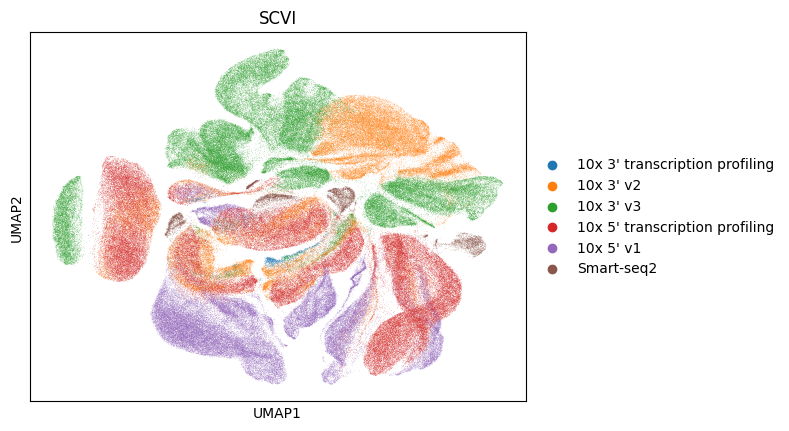

In [23]:
sc.pl.umap(adata, color="assay", title="SCVI")

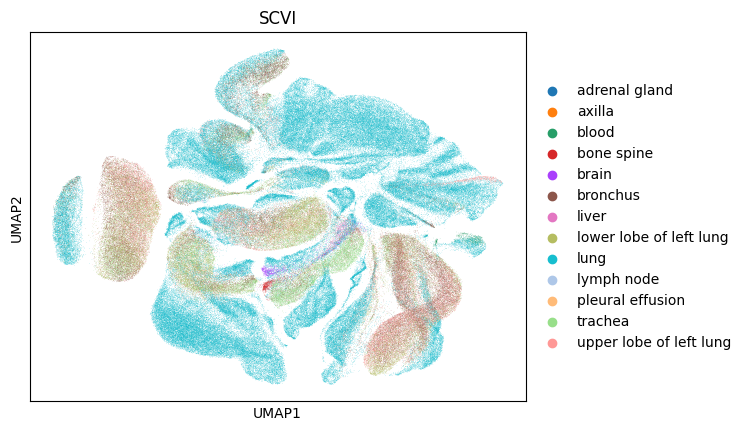

In [24]:
sc.pl.umap(adata, color="tissue", title="SCVI")

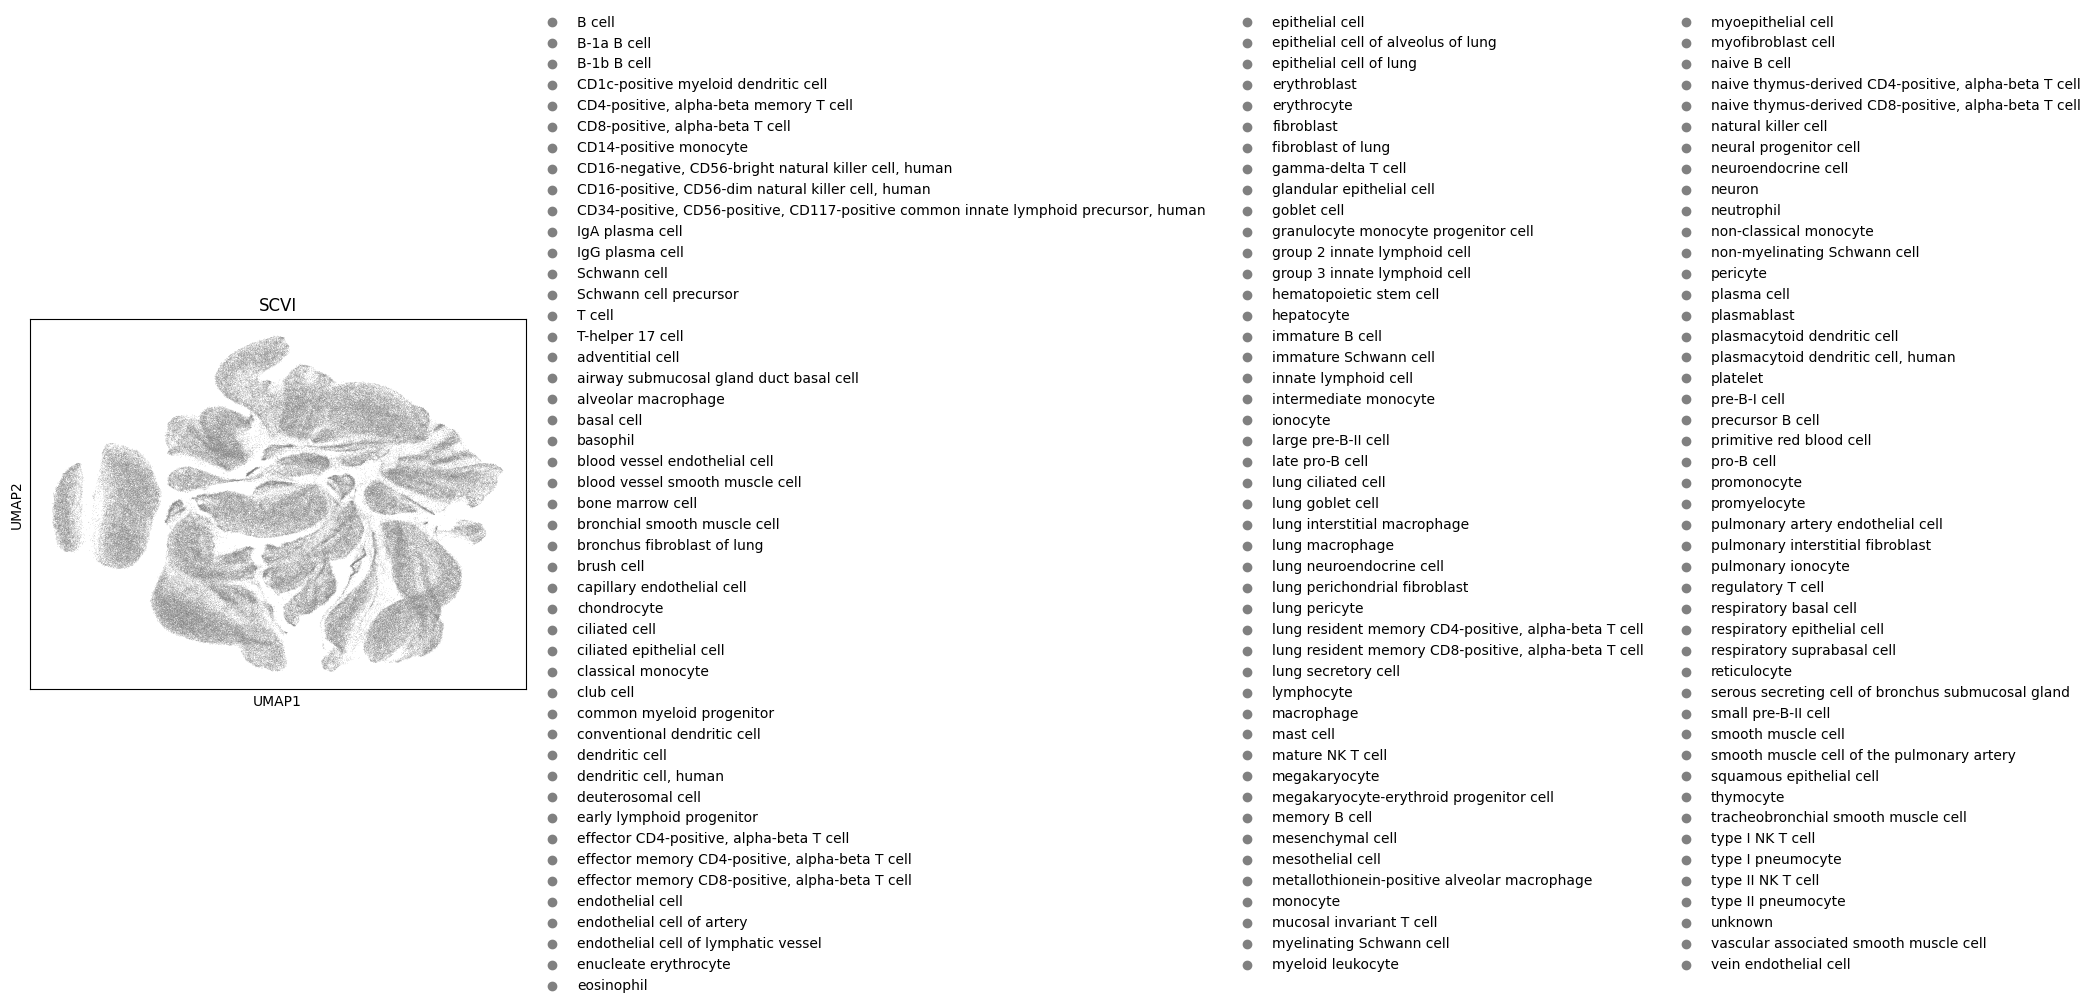

In [25]:
sc.pl.umap(adata, color="cell_type", title="SCVI")